# Reddit text posts crawler

[Based on a Python Reddit API Wrapper](https://praw.readthedocs.io/en/latest/)

In [1]:
import praw
import json
import pickle
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from tqdm import tqdm, trange
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
tqdm.pandas()

All reddit app secrets are stored in the `secrets.json`. You can get the credentials [here](https://www.reddit.com/prefs/apps)

In [3]:
with open('secrets.json', 'r') as f:
    creds = json.loads(f.read())

In [4]:
scrapper = praw.Reddit(**creds)

In [5]:
sub_controller = praw.models.Subreddits(scrapper, None)
subreddits = list(sub_controller.popular(limit=1000))

In [6]:
len(subreddits)

1000

In [8]:
with open('subreddits.txt', 'w') as f:
    for subreddit in subreddits:
        if subreddit.over18:
            continue
        f.write(f'{subreddit.display_name}\n')

In [9]:
subreddits = []
with open('subreddits.txt', 'r') as f:
    for line in f:
        line = line.replace('\n', '')
        if len(line) == 0:
            continue    
        subreddits.append(praw.models.Subreddit(scrapper, display_name=line))

In [11]:
pbar = tqdm(subreddits)
posts = []
DESIRED = 65000
flag = False

for subreddit in pbar:
    subreddit_name = subreddit.display_name
    for post in subreddit.top("all", limit=500):
        if post.over_18:
            continue
        text = post.selftext
        if text is None or len(text) == 0:
            continue
        posts.append([ 
            post.title,
            post.score,
            post.id,
            subreddit_name,
            post.url,
            text,
            post.created
        ])
        pbar.set_description(f'Current number of scraped posts: {len(posts)} / {DESIRED}')
        if len(posts) > DESIRED:
            flag = True
            break
    if flag:
        break

Current number of scraped posts: 65001 / 65000:  55%|█████▍    | 520/950 [1:35:36<1:19:03, 11.03s/it]


In [12]:
len(posts)

65001

## Transforming to dataframe

In [13]:
df = pd.DataFrame(posts, columns=['title', 'score', 'id', 'subreddit', 'url', 'body', 'created'])

In [14]:
df.head()

,title,score,id,subreddit,url,body,created
0,My roommate is kicking me out because having a...,59,ekplmv,Home,https://www.reddit.com/r/Home/comments/ekplmv/...,"So, I am not asking for advice, really...mores...",1.578318e+09
1,Bought a drug house,46,l3538e,Home,https://www.reddit.com/r/Home/comments/l3538e/...,My fiance and I just bought our first house. ...,1.611405e+09
2,Just Bought my First Home,36,m5cuyw,Home,https://www.reddit.com/r/Home/comments/m5cuyw/...,Title says it all: I'm the proud owner of my v...,1.615812e+09
3,(Poorly disguised) ads are showing up too freq...,33,mmp0vu,Home,https://www.reddit.com/r/Home/comments/mmp0vu/...,"I don't know what pushes them up so high, eith...",1.617907e+09
4,I found a fantastic way to naturally make your...,31,naqif5,Home,https://www.reddit.com/r/Home/comments/naqif5/...,I hope this is the correct subreddit to find s...,1.620860e+09


In [15]:
df['len'] =  df['body'].apply(len)

In [16]:
df[df['len'] > 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65001 entries, 0 to 65000
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      65001 non-null  object 
 1   score      65001 non-null  int64  
 2   id         65001 non-null  object 
 3   subreddit  65001 non-null  object 
 4   url        65001 non-null  object 
 5   body       65001 non-null  object 
 6   created    65001 non-null  float64
 7   len        65001 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 4.5+ MB


In [17]:
df.to_csv('large_raw.csv')

In [3]:
df = pd.read_csv('LARGE/raw.csv')

# Transforming database to the corpus

In [18]:
len(df['title'].unique())

64753

In [19]:
len(df[['title', 'body']])

65001

In [4]:
corpus = df.drop('score', axis=1)
corpus.drop(['url', 'created', 'len'], axis=1, inplace=True)

In [5]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65001 entries, 0 to 65000
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  65001 non-null  int64 
 1   title       65001 non-null  object
 2   id          65001 non-null  object
 3   subreddit   65001 non-null  object
 4   body        65001 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.5+ MB


In [6]:
corpus['content'] = corpus['title'] + ' ' + corpus['subreddit'] + ' ' + corpus['body']

In [7]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65001 entries, 0 to 65000
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  65001 non-null  int64 
 1   title       65001 non-null  object
 2   id          65001 non-null  object
 3   subreddit   65001 non-null  object
 4   body        65001 non-null  object
 5   content     65001 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.0+ MB


In [8]:
corpus.drop(['body', 'title', 'subreddit'], axis=1, inplace=True)

In [9]:
corpus.to_csv('large_corpus.csv')

In [10]:
corpus['content_size'] = corpus['content'].apply(len)

In [11]:
corpus['content_size'].mean()

1816.2199043091646

In [12]:
corpus['content_size'].std()

3081.6067458106922

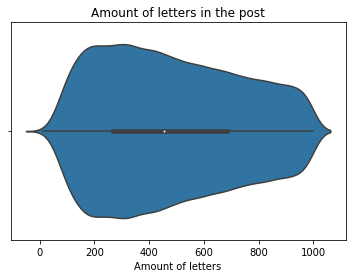

In [13]:
sns.violinplot(x=corpus['content_size'][corpus['content_size'] < 1000])
plt.gca().set_title('Amount of letters in the post')
plt.gca().set_xlabel('Amount of letters')
plt.savefig('corpus_letters')

In [14]:
corpus['content_words'] = corpus['content'].apply(lambda x: x.count(' '))

In [15]:
corpus['content_words'].mean()

300.6569283549484

In [16]:
corpus['content_words'].std()

497.26943013439853

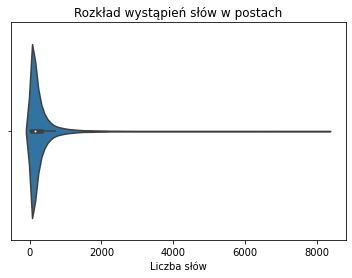

In [18]:
sns.violinplot(x=corpus['content_words'])
plt.gca().set_title('Rozkład wystąpień słów w postach')
plt.gca().set_xlabel('Liczba słów')
plt.savefig('corpus_words')

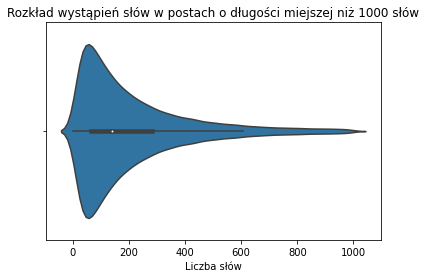

In [19]:
sns.violinplot(x=corpus['content_words'][corpus['content_words'] < 1000])
plt.gca().set_title('Rozkład wystąpień słów w postach o długości miejszej niż 1000 słów')
plt.gca().set_xlabel('Liczba słów')
plt.savefig('corpus_words_small')

## Text clenaup

In [3]:
import nltk
import emoji
import string
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [4]:
def preprocess_text(document, normalize=True, drop_numbers=False, drop_punctuations=True, drop_stopwords=True, stem=True, stop_words=None, drop_potential_links=False, transform_emoji=True, drop_nonascii=True):
    if transform_emoji:
        document = emoji.demojize(document)
    if drop_punctuations:
        document = ''.join(char for char in document if char not in string.punctuation)
    if drop_numbers:
        document = ''.join(char for char in document if char not in string.digits)
    if drop_nonascii:
        document = document.encode('ascii', errors='ignore').decode()
    tokens = word_tokenize(document)
    if stem:
        porter = PorterStemmer()
        tokens = [porter.stem(token) for token in tokens]
    if drop_stopwords:
        if stop_words is None:
            stop_words = stopwords.words('english')
        tokens = [token for token in tokens if token not in stop_words]
    if drop_potential_links:
        tokens = list(filter(lambda x : 'http' not in x, tokens))
    return tokens

In [3]:
corpus = pd.read_csv('LARGE/corpus.csv')

In [11]:
corpus['preprocessed'] = corpus['content'].progress_apply(lambda x: preprocess_text(x, drop_numbers=True, drop_potential_links=True, transform_emoji=True))

100%|██████████| 65001/65001 [16:06<00:00, 67.23it/s]  


In [13]:
corpus.head()

,Unnamed: 0,id,content,preprocessed
0,0,ekplmv,My roommate is kicking me out because having a...,"[roommat, kick, becaus, femal, roomat, ruin, h..."
1,1,l3538e,Bought a drug house Home My fiance and I just ...,"[bought, drug, hous, home, fianc, bought, firs..."
2,2,m5cuyw,Just Bought my First Home Home Title says it a...,"[bought, first, home, home, titl, say, im, pro..."
3,3,mmp0vu,(Poorly disguised) ads are showing up too freq...,"[poorli, disguis, ad, show, frequent, home, do..."
4,4,naqif5,I found a fantastic way to naturally make your...,"[found, fantast, way, natur, make, hous, smell..."


In [15]:
# to_save = corpus.drop(['content_size', 'content_words'], axis=1)
corpus.to_pickle('preprocessed.pickle')

In [36]:
corpus = pd.read_pickle('preprocessed.pickle')

# Gather vocabulary

In [42]:
vocab = set([
  word for sentence in corpus['preprocessed'] for word in sentence  
])

In [43]:
len(vocab)

172881

In [22]:
vocab_map = {
    word: i
    for i, word in enumerate(vocab)
}

In [23]:
word_freq = [0] * len(vocab)
for document in corpus['preprocessed']:
    for word in set(document):
        word_freq[vocab_map[word]] += 1

In [24]:
corpus_size = len(corpus['preprocessed'])
idf_map = {
    i: np.log(corpus_size / freq) if freq > 0 else 0
    for i, freq in enumerate(word_freq)
}

In [37]:
counter = Counter([word for sentence in corpus['preprocessed'] for word in sentence])

In [38]:
y = [x[1] for x in counter.most_common()]

(10000.0, 172881.0)

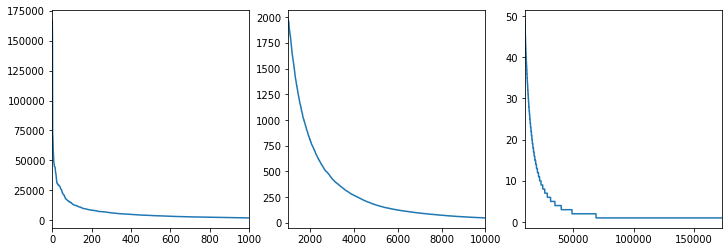

In [39]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
ax[0].plot(range(1000), y[:1000])
ax[0].set_xlim(-1, 1000)
ax[1].plot(range(1000, 10000), y[1000:10000])
ax[1].set_xlim(1000, 10000)
ax[2].plot(range(10000, len(y)), y[10000:])
ax[2].set_xlim(10000, len(y))

In [47]:
np.sum(np.array(y) <= 30)

160029

In [68]:
Y = np.array(y)
np.sum(Y[Y > 30]) / np.sum(Y)

0.9576345399972106

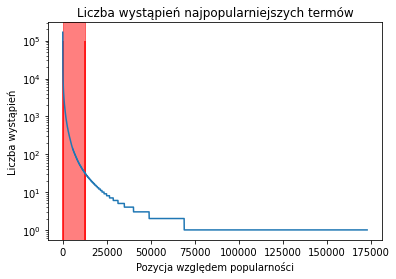

In [83]:
plt.plot(y)
plt.yscale('log')
plt.vlines([np.sum(Y >= 30000), np.sum(Y > 30)], 0, 1e5, colors='red')
plt.axvspan(np.sum(Y >= 30000), np.sum(Y > 30), alpha=0.5, color='red')
plt.title('Liczba wystąpień najpopularniejszych termów')
plt.ylabel('Liczba wystąpień')
plt.xlabel('Pozycja względem popularności')
plt.savefig('popularity')

In [49]:
wf = {
    x[0]: x[1]
    for x in counter.most_common()
}

In [59]:
vocab = set([
    word for sentence in corpus['preprocessed'] for word in sentence if wf[word] > 30 and wf[word] < 30000
])

vocab_map = {
    word: i
    for i, word in enumerate(vocab)
}

In [60]:
len(vocab)

12824

In [61]:
word_freq = [0] * len(vocab)
for document in corpus['preprocessed']:
    for word in set(document):
        if word in vocab_map:
            word_freq[vocab_map[word]] += 1

In [62]:
corpus_size = len(corpus['preprocessed'])
idf_map = {
    i: np.log(corpus_size / freq) if freq > 0 else 0
    for i, freq in enumerate(word_freq)
}

In [63]:
def save_obj(vocab_map, file):
    with open(file, 'wb') as f:
        pickle.dump(vocab_map, f)
    
def load_obj(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [64]:
save_obj(vocab_map, 'opt_map.pickle')

In [7]:
vocab_map = load_obj('OPT/map.pickle')

In [65]:
save_obj(idf_map, 'opt_idf_map.pickle')

# Transform to term-by-document matrix

In [66]:
def veccount_data(data, vocab_map, normalize=False, idf_map=None):
    if idf_map is None:
        idf_map = [1] * len(vocab_map)
    matrix = sparse.dok_matrix((len(vocab_map), len(data)), dtype='float')
    current_vec = np.empty(len(vocab_map))
    for i, doc in tqdm(enumerate(data)):
        current_vec[...] = 0 
        # Eval normalization constant
        for member in doc:
            if member in vocab_map:
                current_vec[vocab_map[member]] += idf_map[vocab_map[member]]
        # Assign elements and normalize them
        vec_norm = np.linalg.norm(current_vec)
        if normalize:
            current_vec /= vec_norm
        for x in np.nonzero(current_vec):
            matrix[x, i] = current_vec[x]
    return matrix.tocsc()

In [84]:
matrix = veccount_data(corpus['preprocessed'], vocab_map, normalize=True, idf_map=idf_map)

65001it [01:14, 870.76it/s] 


In [67]:
f'Matrix size in memory: {3 * matrix.data.nbytes / 10000000} MB'

'Matrix size in memory: 13.6372104 MB'

In [86]:
sparse.save_npz('opt_idf.npz', matrix)

In [2]:
matrix = sparse.load_npz('OPT/idf.npz')

## Search engine tests

In [70]:
small_db = pd.read_csv('OPT/smalldb.csv')

In [71]:
query_data = preprocess_text('how to learn to code', drop_numbers=True, drop_potential_links=True, transform_emoji=True)
query_data

['learn', 'code']

In [72]:
vec = veccount_data([query_data], vocab_map, normalize=True, idf_map=idf_map)

1it [00:00, 109.89it/s]


In [73]:
sol = np.asarray((vec.T @ matrix).todense()).argsort()[0]

In [74]:
small_db.iloc[sol[-20:][::-1]]

,Unnamed: 0,title,subreddit,url,body
23234,23234,Break From Coding,learnprogramming,https://www.reddit.com/r/learnprogramming/comm...,I have been learning Java for about 6 months n...
22817,22817,"If you are learning programming(newbie), these...",learnprogramming,https://www.reddit.com/r/learnprogramming/comm...,As many ask for free resources in this vast wo...
20825,20825,PSA: To new programmers or to those new to pos...,learnpython,https://www.reddit.com/r/learnpython/comments/...,I've had some spare time to parse this subredd...
22981,22981,Just a simple piece of advice as I code more e...,learnprogramming,https://www.reddit.com/r/learnprogramming/comm...,I noticed when I first started learning to cod...
22993,22993,Code Wars is my favourite resource as a beginner,learnprogramming,https://www.reddit.com/r/learnprogramming/comm...,** Absolutely no affiliation to Code Wars. \n\...
23059,23059,Have ADHD and wanna learn how to code? You can...,learnprogramming,https://www.reddit.com/r/learnprogramming/comm...,I just wanna make a motivational post for my f...
22897,22897,How to actually stay motivated to learn how to...,learnprogramming,https://www.reddit.com/r/learnprogramming/comm...,"Hey Reddit,\nLearning to code is a bitch.\n\nI..."
21061,21061,Do you know any GitHub Users who write really ...,learnpython,https://www.reddit.com/r/learnpython/comments/...,Hey I am a Beginner in Python and I would like...
23191,23191,12 free games to learn programming.,learnprogramming,https://www.reddit.com/r/learnprogramming/comm...,I stumbled upon [12 Free Games to Learn Progra...
23116,23116,Learn JavaScript By Coding Flappy Bird And Sna...,learnprogramming,https://www.reddit.com/r/learnprogramming/comm...,https://www.youtube.com/watch?v=9TcU2C1AACw&li...


In [60]:
small_db = df.drop(['score', 'id', 'created', 'len'], axis=1)
small_db.to_csv('large_smalldb.csv')

In [61]:
small_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65001 entries, 0 to 65000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      65001 non-null  object
 1   subreddit  65001 non-null  object
 2   url        65001 non-null  object
 3   body       65001 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


## Low rank approximation

We will calculate only first 1500 singular values

In [3]:
u, s, v_t = sparse.linalg.svds(matrix, k=1500)

In [4]:
with open('svd.pickle', 'wb') as f:
    pickle.dump((u, s, v_t), f)

In [10]:
with open('OPT/svd.pickle', 'rb') as f:
    (u, s, v_t) = pickle.load(f)